<a href="https://colab.research.google.com/github/athanimadhu/Supervised_finetuning_ViT_LoRA/blob/main/Code/Finetuning_ViT_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SUPERVISED FINETUNING FOR OBJECT COUNTING WITH ViT and LoRA**

ViT used: google/vit-base-patch16-224-in21k from Hugging face

Make sure to swith your run time to GPU

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer, ViTImageProcessor
from torch import nn
from peft import LoraConfig, get_peft_model
from datasets import Dataset, load_from_disk
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Data: Using custom data with overlapping filaments (objects)

In [4]:
# Define the base path to the dataset
base_path = '/content/drive/MyDrive/Colab Notebooks/Fine-tuning/'

# Load datasets
train_df = pd.read_csv(base_path + 'train_data.csv')
validation_df = pd.read_csv(base_path + 'val_data.csv')
test_df = pd.read_csv(base_path + 'test_data.csv')

# Add full paths to the images
train_df['full_path'] = base_path + train_df['Relative_File_Path']
validation_df['full_path'] = base_path + validation_df['Relative_File_Path']
test_df['full_path'] = base_path + test_df['Relative_File_Path']

# Check the first few rows
print(train_df.head())

                               Relative_File_Path  Number_of_Chains  \
0      Training/Lx50_BD01_C0_nematic_00720000.png                16   
1  Training/Kappa100_BD05_C2_nematic_10650000.png               726   
2   Training/Lx150_BD0359_C1_nematic_00600000.png               359   
3  Training/Kappa300_BD07_C1_nematic_03075000.png              1016   
4     Training/Lx100_BD07_C2_nematic_00765000.png               452   

                                           full_path  
0  /content/drive/MyDrive/Colab Notebooks/Fine-tu...  
1  /content/drive/MyDrive/Colab Notebooks/Fine-tu...  
2  /content/drive/MyDrive/Colab Notebooks/Fine-tu...  
3  /content/drive/MyDrive/Colab Notebooks/Fine-tu...  
4  /content/drive/MyDrive/Colab Notebooks/Fine-tu...  


Print some image to see how it looks

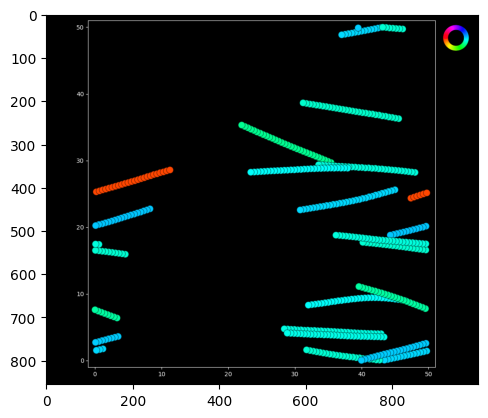

In [ ]:
img_path = train_df.iloc[0]['full_path']
img = Image.open(f'{img_path}')
plt.imshow(img)
plt.show()

Converts the dataframe to a huggingface dataset. If you have already done this step and saved the dataset, skip to next step where you can load the dataset from stored data.

In [5]:
# Load the feature extractor
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

label_scaler = 1200.0  # Maximum label value to normalize against

def preprocess(example):
    # Load the image
    img = Image.open(example['full_path']).convert("RGB")

    # Apply feature extraction
    inputs = feature_extractor(images=img, return_tensors="pt")

    # Explicitly cast `pixel_values` to a torch.Tensor
    example['pixel_values'] = inputs['pixel_values'][0]

    # Convert `labels` to a tensor (for regression)
    example['label'] = torch.tensor([example['Number_of_Chains']/label_scaler], dtype=torch.float32)

    return example

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Preprocessing data

In [ ]:
# Convert DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

# Apply preprocessing
train_dataset = train_dataset.map(preprocess, batched=False, load_from_cache_file=False)
validation_dataset = validation_dataset.map(preprocess, batched=False, load_from_cache_file=False)
test_dataset = test_dataset.map(preprocess, batched=False, load_from_cache_file=False)

# Force the dataset to return PyTorch tensors for pixel_values and labels
train_dataset.set_format(type='torch', columns=['pixel_values', 'label'])
validation_dataset.set_format(type='torch', columns=['pixel_values', 'label'])
test_dataset.set_format(type='torch', columns=['pixel_values', 'label'])

# Remove the extra columns
train_dataset = train_dataset.remove_columns(['Relative_File_Path', 'Number_of_Chains', 'full_path'])
validation_dataset = validation_dataset.remove_columns(['Relative_File_Path', 'Number_of_Chains', 'full_path'])
test_dataset = test_dataset.remove_columns(['Relative_File_Path', 'Number_of_Chains', 'full_path'])

# Save the preprocessed datasets to the base directory
train_dataset.save_to_disk(f"{base_path}/preprocessed_train")
validation_dataset.save_to_disk(f"{base_path}/preprocessed_validation")
test_dataset.save_to_disk(f"{base_path}/preprocessed_test")

Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

Map:   0%|          | 0/504 [00:00<?, ? examples/s]

Map:   0%|          | 0/504 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/2352 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/504 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/504 [00:00<?, ? examples/s]

Load the preprocessed dataset if present

In [6]:
# Load the datasets from the base directory
train_dataset = load_from_disk(f"{base_path}/preprocessed_train")
validation_dataset = load_from_disk(f"{base_path}/preprocessed_validation")
test_dataset = load_from_disk(f"{base_path}/preprocessed_test")

In [7]:
print(train_dataset['label'].shape)
print(validation_dataset['label'].shape)
print(test_dataset['label'].shape)

torch.Size([2352, 1])
torch.Size([504, 1])
torch.Size([504, 1])


In [8]:
train_dataset[0]['label']

tensor([0.0133])

In [ ]:
print(train_dataset['pixel_values'].shape)
print(validation_dataset['pixel_values'].shape)
print(test_dataset['pixel_values'].shape)

In [9]:
# Define batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debug the structure of a batch
for batch in train_loader:
    print(batch["pixel_values"].shape)  # Should be [batch_size, 3, 224, 224]
    print(batch["label"].shape)         # Should be [batch_size, 1]
    break

torch.Size([16, 3, 224, 224])
torch.Size([16, 1])


In [11]:
# 1. Load the pre-trained model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
model.config.problem_type = None
model.config.num_labels = 1      # Specify a single output for regression

# 4. Replace the classifier head with a regression head
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),  # Output a single scalar value
)

# Step 5: Manually initialize weights and biases for larger outputs
label_scaler = 1500.0  # Scale your labels based on preprocessing
model.classifier[0].weight.data.normal_(mean=0.0, std=0.02)  # Initialize weights
model.classifier[0].bias.data.fill_(0.5)  # Initialize bias near the center of the label range

# 2. Configure LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value"],
    inference_mode=False
)

# 3. Apply LoRA to the model
model = get_peft_model(model, lora_config)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.print_trainable_parameters()

trainable params: 294,912 || all params: 86,094,337 || trainable%: 0.3425


In [13]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): ViTForImageClassification(
      (vit): ViTModel(
        (embeddings): ViTEmbeddings(
          (patch_embeddings): ViTPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): ViTEncoder(
          (layer): ModuleList(
            (0-11): 12 x ViTLayer(
              (attention): ViTSdpaAttention(
                (attention): ViTSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
               

In [19]:
# 3. Define the optimizer
import torch.optim as optim

# If you want to use the mean absulate error as the loss funciton, it is not inbuilt. This can be used
# class MAELoss(nn.Module):
#     def forward(self, y_pred, y_true):
#         return torch.mean(torch.abs(y_pred - y_true))

# Example usage
# criterion = MAELoss()
# loss = criterion(y_pred, y_true)
# print(f"MAE Loss: {loss.item()}")


# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)


If you want to debug by adding a hook, or even want to see the weights flow after the LoRA.A and LoRA.B matrices

In [ ]:
# def hook_fn(module, inputs, outputs):
#     print(f"Inputs to {module}: {inputs[0].mean().item()}, Outputs: {outputs.mean().item()}")

# # Register the hook for a specific layer
# lora_layer = model.base_model.model.vit.encoder.layer[4].attention.attention.query.lora_A.default
# hook = layer.register_forward_hook(hook_fn)
# print(f"Hook attached to: {lora_layer}")


# # hook = lora_layer.register_forward_hook(hook_fn)
# hook.remove()
# print(f"Active hooks before removal: {lora_layer._forward_hooks}")
# hook.remove()
# print(f"Active hooks before removal: {lora_layer._forward_hooks}")


Make sure to remove the hooks after debugging

In [ ]:
# hooks_to_remove = list(lora_layer._forward_hooks.keys())
# for hook_id in hooks_to_remove:
#     del lora_layer._forward_hooks[hook_id]

Training is done using a custom training fucntion defined using PyTorch

In [ ]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["label"].to(device).squeeze(-1)  # Ensure labels have the correct shape

        # Forward pass
        outputs = model(pixel_values)
        logits = outputs.logits.squeeze(-1)  # Ensure logits match labels

        # Compute loss
        loss = criterion(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


In [ ]:
def evaluate_model(model, validation_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in validation_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["label"].to(device).squeeze(-1)

            # Forward pass
            outputs = model(pixel_values)
            logits = outputs.logits.squeeze(-1)

            # Compute loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

    return total_loss / len(validation_loader)


In [ ]:
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loss_history = []
validation_loss_history = []
for epoch in range(epochs):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    validation_loss = evaluate_model(model, validation_loader, criterion, device)
    train_loss_history.append(train_loss)
    validation_loss_history.append(validation_loss)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Training Loss: {train_loss:.6f}")
    print(f"  Validation Loss: {validation_loss:.6f}")


Epoch 1/5
  Training Loss: 0.004218
  Validation Loss: 0.004089
Epoch 2/5
  Training Loss: 0.003858
  Validation Loss: 0.003813
Epoch 3/5
  Training Loss: 0.003541
  Validation Loss: 0.003572
Epoch 4/5
  Training Loss: 0.003305
  Validation Loss: 0.003374
Epoch 5/5
  Training Loss: 0.003083
  Validation Loss: 0.003246


In [17]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["label"].to(device).squeeze(-1)

            # Forward pass
            outputs = model(pixel_values)
            logits = outputs.logits.squeeze(-1)

            # Compute loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Store predictions and ground truths for analysis
            predictions.extend(logits.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    return avg_loss, predictions, ground_truths


In [20]:
test_loss, predictions, ground_truths = test_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.6f}")


Test Loss: 0.002724


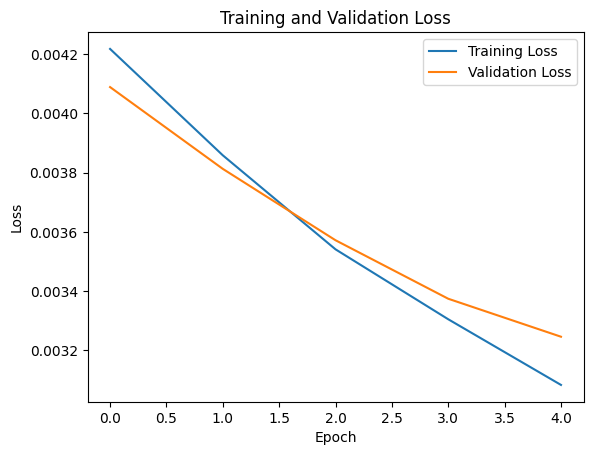

In [ ]:
import matplotlib.pyplot as plt

epochs = range(0, 5)  # Adjust based on your number of epochs
# train_losses = [0.045, 0.006, 0.003, 0.002, 0.002]  # Replace with actual values
# validation_losses = [0.050, 0.007, 0.004, 0.003, 0.003]  # Replace with actual values

plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, validation_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Mean absolute percentage error: 20.61106954557378


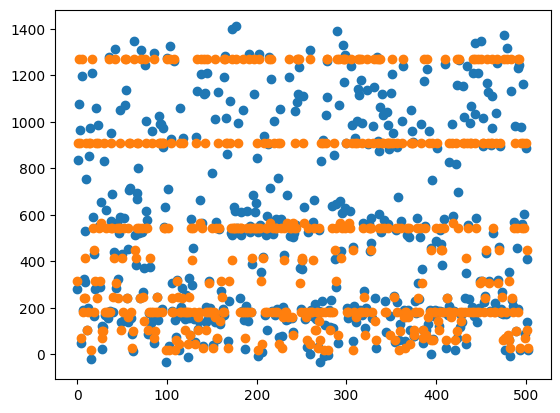

In [24]:
predictions_new =np.zeros(len(predictions))
ground_truths_new =np.zeros(len(ground_truths))
error = np.zeros(len(predictions))
for i in range(len(predictions)):
    predictions_new[i] = predictions[i] * label_scaler
    ground_truths_new[i] = ground_truths[i] * label_scaler
    error[i] = np.abs((ground_truths_new[i]- predictions_new[i])/ground_truths_new[i])
    # print(f"Prediction: {predictions_new[i]}, Ground Truth: {ground_truths_new[i]}, Error: {error[i]}")
    # print(predictions_new[i], ground_truths_new[i])
final_error = np.mean(error)
print(f"Mean absolute percentage error: {100*final_error}")
plt.plot(predictions_new, 'o')
plt.plot(ground_truths_new, 'o')
# plt.xlabel('Ground Truth')
# plt.ylabel('Predictions')

Save the model

In [ ]:
import os
model_path = os.path.join(base_path, "vit_lora_regression.pth")

# Save the state dictionary of the model
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Colab Notebooks/Fine-tuning/vit_lora_regression.pth


Load your model if you have already saved it

In [14]:
# Load model
import os
model_path = os.path.join(base_path, "vit_lora_regression.pth")
model.load_state_dict(torch.load(model_path))
model.to(device)

<ipython-input-14-9397e78d36ac>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


PeftModel(
  (base_model): LoraModel(
    (model): ViTForImageClassification(
      (vit): ViTModel(
        (embeddings): ViTEmbeddings(
          (patch_embeddings): ViTPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): ViTEncoder(
          (layer): ModuleList(
            (0-11): 12 x ViTLayer(
              (attention): ViTSdpaAttention(
                (attention): ViTSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
               